In [2]:
# import necessary modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.optimize import minimize_scalar, root_scalar
from math import pi

matplotlib.rcParams['font.family'] = 'serif'

Text(0.5, 1.0, 'Potential')

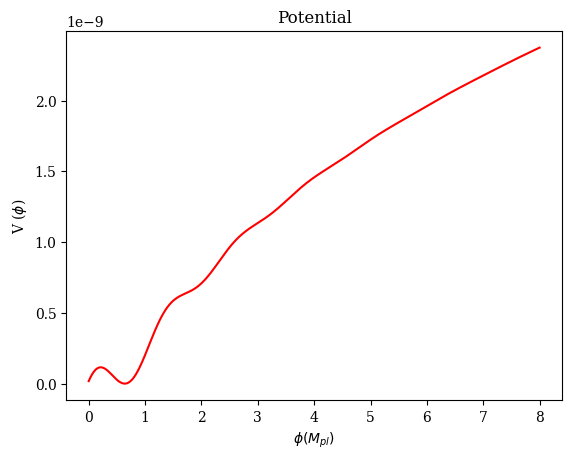

In [3]:
#Potencial given
phi_pot = np.linspace(0,8,500)

#parameters
f = 0.2
delta = -1
p_Lamb = 1
phi_Lamb = 1.15
p = 1/6
F = 0.75
m = 3.5e-5
kappa = 5

#to graph the potencial we need the V0 that ensures V=0 at the global minimum
V_ini = lambda phi: m*m*f*f*(1/(2*p)*F*F/f/f*(-1+np.power(1+phi*phi/F/F,p))+kappa*np.exp(-np.power(phi/phi_Lamb,p_Lamb))*np.cos(phi/f+delta))

minimum_potential = minimize_scalar(V_ini,bounds=(0,1),method='bounded')
V0 = -V_ini(minimum_potential.x)

V = lambda phi: m*m*f*f*(1/(2*p)*F*F/f/f*(-1+np.power(1+phi*phi/F/F,p))+kappa*np.exp(-np.power(phi/phi_Lamb,p_Lamb))*np.cos(phi/f+delta))+V0
dV = lambda phi: m*m*f*f*(phi/f/f*np.power(1+phi*phi/F/F,p-1)
                -kappa*np.exp(-np.power(phi/phi_Lamb,p_Lamb))*(1/f*np.sin(phi/f+delta)+p_Lamb/phi_Lamb*np.power(phi/phi_Lamb,p_Lamb-1)*np.cos(phi/f+delta)))
ddV = lambda phi: m*m*f*f*((1+(2*p-1)*phi*phi/F/F)/f/f*np.power(1+phi*phi/F/F,p-2)
                -kappa*np.exp(-np.power(phi/phi_Lamb,p_Lamb))*(1/f/f*np.cos(phi/f+delta)+p_Lamb/phi_Lamb*np.power(phi/phi_Lamb,p_Lamb-2)*
                (((p_Lamb-1)/phi_Lamb-p_Lamb/phi_Lamb*np.power(phi/phi_Lamb,p_Lamb))*np.cos(phi/f+delta)-2/f*phi/phi_Lamb*np.sin(phi/f+delta))))

#Figure for the potencial given
fig_pot, ax_pot = plt.subplots()

ax_pot.plot(phi_pot,V(phi_pot),color='r', linestyle='-')
ax_pot.set_xlabel(r'$\phi (M_{pl})$')
ax_pot.set_ylabel(r'V ($\phi$)')
ax_pot.set_title('Potential')

In [4]:
#relevant parameters
H_2N = lambda phi,dphi: V(phi)/(3-dphi*dphi/2)

epsN = lambda dphi: dphi*dphi/2
etaN = lambda phi, dphi: 3+dV(phi)/H_2N(phi,dphi)/dphi

#slow-roll parameters
eps_v = lambda phi: 1/2*(dV(phi)/V(phi))*(dV(phi)/V(phi))
eta_v = lambda phi: ddV(phi)/V(phi)
HSR_2 = lambda phi: V(phi)/3 #H in slow-roll

#initial values for the slow-roll regime
phiSR_0 = 8
dphiNSR_0 = -np.sqrt(2*eps_v(phiSR_0))

Text(0.5, 1.0, '$\\eta$ parameter')

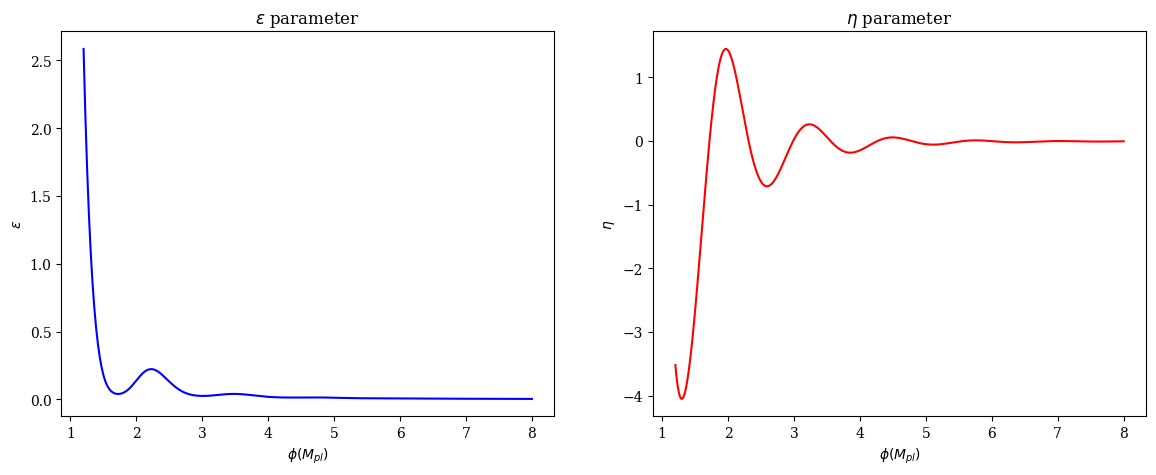

In [5]:
phiSR = np.linspace(1.2,phiSR_0,500)

#Figure for the slow-roll parameters
fig_SR = plt.figure()
fig_SR.set_figheight(5)
fig_SR.set_figwidth(14)

ax_eps = plt.subplot(1,2,1)
ax_eta = plt.subplot(1,2,2)

ax_eps.plot(phiSR,eps_v(phiSR),color='b', linestyle='-')
ax_eps.set_ylabel(r'$\epsilon$')
ax_eps.set_xlabel(r'$\phi (M_{pl})$')
ax_eps.set_title(r'$\epsilon$ parameter')

ax_eta.plot(phiSR,eta_v(phiSR),color='r', linestyle='-')
ax_eta.set_ylabel(r'$\eta$')
ax_eta.set_xlabel(r'$\phi (M_{pl})$')
ax_eta.set_title(r'$\eta$ parameter')

Klein-Gordon equations for the background potencial, respect e-folds

In [6]:
def kg_N (N,phi_arr): #complete KG (respect N)
    phi, dphi = phi_arr

    y = dphi
    y_der = -(3-epsN(dphi))*y-dV(phi)/H_2N(phi,dphi)

    return [y,y_der]

To compute the background inflation we need to obtain the value of $\phi$ where inflation ends: $\epsilon_V = 1$

In [7]:
#number of e-folds of inflation
eps_1 = lambda phi: eps_v(phi)-1
sol_zeros = root_scalar(eps_1, bracket=[1,2], method='brentq')
phi_e = sol_zeros.root

dN = lambda phi: 1/np.sqrt(2*eps_v(phi))
N_int = quad(dN,phi_e, phiSR_0)
N_end = N_int[0]
print('End of inflation: %.2f e-folds'%N_end)

End of inflation: 43.05 e-folds


We compute the background inflation and the inflaton 2-efolds after the end of inflation

Text(0.5, 1.0, 'Inflaton evolution (after inflation)')

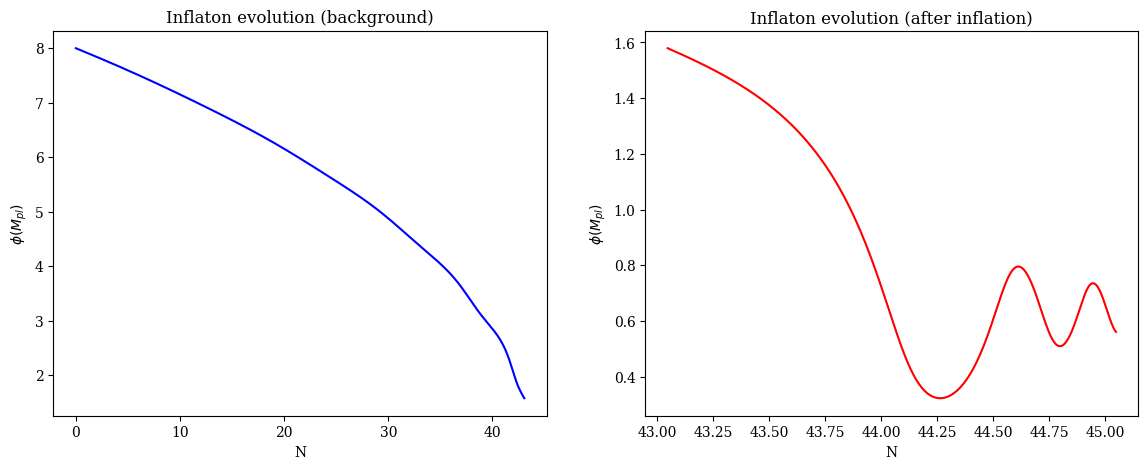

In [8]:
#numerical integration respect e-folds 
N_0 = 0
N_eval = np.linspace(N_0, N_end,1000)
N_span = np.array([N_0,50])
phiN_arr_0 = [phiSR_0, dphiNSR_0]
sol_back = solve_ivp(kg_N,N_span, phiN_arr_0, method='BDF',dense_output=True, rtol=1e-10, atol=1e-10)

phiN = sol_back.sol(N_eval)[0]
dphiN = sol_back.sol(N_eval)[1]

#e-folds after inflation
N_aft = np.linspace(N_end,N_end+2,500)
phi_aft = sol_back.sol(N_aft)[0]
dphi_aft = sol_back.sol(N_aft)[1]

#Figure for the inflaton (background)
fig_phi = plt.figure()
fig_phi.set_figheight(5)
fig_phi.set_figwidth(14)

ax_phiN = plt.subplot(1,2,1)
ax_aft = plt.subplot(1,2,2)

ax_phiN.plot(N_eval,phiN,color='b', linestyle='-')
ax_phiN.set_xlabel(r'N')
ax_phiN.set_ylabel(r'$\phi (M_{pl})$')
ax_phiN.set_title('Inflaton evolution (background)')

ax_aft.plot(N_aft,phi_aft,color='r', linestyle='-')
ax_aft.set_xlabel(r'N')
ax_aft.set_ylabel(r'$\phi (M_{pl})$')
ax_aft.set_title('Inflaton evolution (after inflation)')

Now we plot the equation of state: $w = p/\rho$

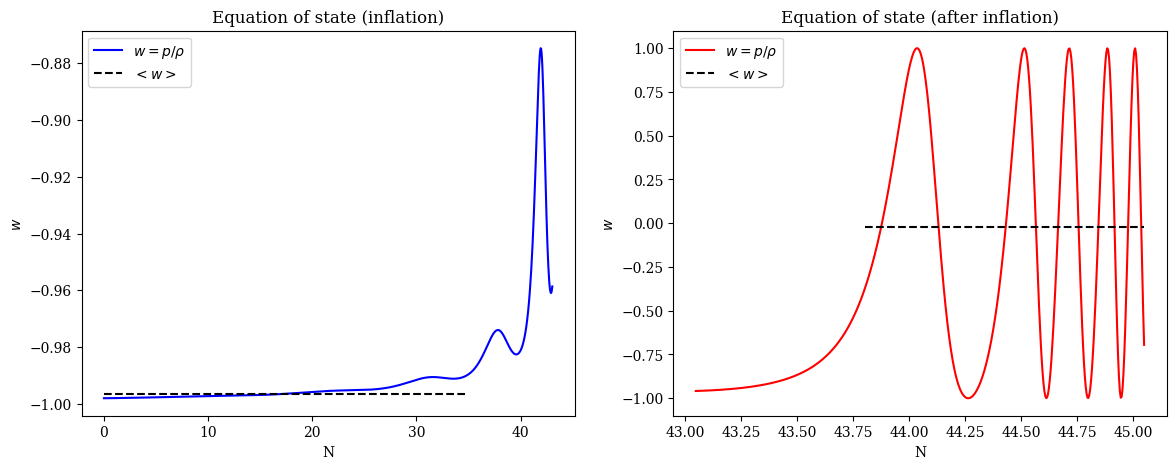

In [9]:
#pressure and density
rho = lambda phi,dphi: H_2N(phi,dphi)*dphi*dphi/2+V(phi)
pr = lambda phi,dphi: H_2N(phi,dphi)*dphi*dphi/2-V(phi)

#w for inflation
w = pr(phiN,dphiN)/rho(phiN,dphiN)
w_aft = pr(phi_aft,dphi_aft)/rho(phi_aft,dphi_aft)

#average value
N_av_end = 35
N_av = np.where(N_eval < N_av_end)
h = N_eval[1]-N_eval[0]
w_av = w[N_av]
w_av = sum(w_av*h)/N_av_end

N_aft_av_0 = 43.8
N_aft_av = np.where(N_aft>N_aft_av_0)
h_aft = N_aft[1]-N_aft[0]
w_aft_av = w_aft[N_aft_av]
w_aft_av = sum(w_aft_av*h_aft)/(N_aft[-1]-N_aft_av_0)

#Figure for the inflaton (background)
fig_phi = plt.figure()
fig_phi.set_figheight(5)
fig_phi.set_figwidth(14)

ax_phi = plt.subplot(1,2,1)
ax_aft = plt.subplot(1,2,2)

ax_phi.plot(N_eval,w,color='b', linestyle='-', label=r'$w=p/\rho$')
ax_phi.plot(N_eval[N_av],w_av*np.ones(len(N_eval[N_av])), color='k', linestyle='--', label=r'$<w>$')
ax_phi.set_xlabel(r'N')
ax_phi.set_ylabel(r'$w$')
ax_phi.set_title('Equation of state (inflation)')
ax_phi.legend()

ax_aft.plot(N_aft,w_aft,color='r', linestyle='-',label=r'$w=p/\rho$')
ax_aft.plot(N_aft[N_aft_av],w_aft_av*np.ones(len(N_aft[N_aft_av])), color='k', linestyle='--', label=r'$<w>$')
ax_aft.set_xlabel(r'N')
ax_aft.set_ylabel(r'$w$')
ax_aft.set_title('Equation of state (after inflation)')
ax_aft.legend()

After computing the inflation background, we are going to consider the inflation perturbations and obtain the power spectrum

In [10]:
#initial conditions (reference)
a = lambda N: np.exp(N) #it is define a=1 at N=0

#root finding k=aH
def root_k(N,k):
    phi = sol_back.sol(N)[0]
    dphi = sol_back.sol(N)[1]

    root = np.exp(N)-k/np.sqrt(H_2N(phi,dphi))

    return root

#initial conditions for perturbations
def num_int_pert(k):
    k_i = k/100
    sol_zeros = root_scalar(root_k, args=[k], bracket=[0,N_end], method='brentq')
    N_eq = sol_zeros.root

    #initial condition
    sol_zeros = root_scalar(root_k, args=[k_i], bracket=[0,N_end], method='brentq')
    N_i = sol_zeros.root
    a_i =  a(N_i) #initial condition for H

    # numerical integration arrays
    N_span = np.array([N_i,N_eq+10])

    return [a_i,N_i,N_eq,N_span]

Mukhanov-Sasaki equation and Bunch-Davies conditions:

In [11]:
def MSN (N,u_arr, k): #mukhanov-sasaki equation for scalar fluctuations
    u, du = u_arr
    phi_back = sol_back.sol(N)[0]
    dphiN_back = sol_back.sol(N)[1]

    y = du
    y_der = -(1-epsN(dphiN_back))*y-(k*k/(a(N)*a(N)*H_2N(phi_back, dphiN_back))
            +ddV(phi_back)/H_2N(phi_back,dphiN_back)-2*epsN(dphiN_back)*(3+epsN(dphiN_back)-2*etaN(phi_back,dphiN_back))-(2-epsN(dphiN_back)))*u

    return [y,y_der]

def MSN_t (N,u_arr, k): #mukhanov-sasaki equation for tensor fluctuations
    u, du = u_arr
    phi_back = sol_back.sol(N)[0]
    dphiN_back = sol_back.sol(N)[1]

    y = du
    y_der = -(1-epsN(dphiN_back))*y-(k*k/(a(N)*a(N)*H_2N(phi_back, dphiN_back))-(2-epsN(dphiN_back)))*u

    return [y,y_der]

#for u
u_0_RE = lambda k: 1/np.sqrt(2*k)
du_0_RE = lambda k: 0
u_0_IM = lambda k: 0
du_0_IM = lambda k: -np.sqrt(k/2)/(k/100)

#tolerances
rtol_pert = 1e-8
atol_pert = 1e-8

Now we compute the power spectrum

In [12]:
#values for power spectrum
N_first = 5
k_first = a(N_first)*np.sqrt(H_2N(sol_back.sol(N_first)[0],sol_back.sol(N_first)[1]))
N_last = N_end-2
k_last = a(N_last)*np.sqrt(H_2N(sol_back.sol(N_first)[0],sol_back.sol(N_first)[1]))
k_arr = np.logspace(np.log10(k_first),np.log10(k_last),300)

P_R = [] #scalar fluctuations
P_R_SR = []
P_t = [] #tensor fluctuations
P_t_SR = []

for k in k_arr:
    # numerical integration
    a_i,N_i,N_eq,N_span, = num_int_pert(k)
    N_eval = N_eq+2

    #background
    phi_back = sol_back.sol(N_eval)[0]
    dphi_back = sol_back.sol(N_eval)[1]

    uarr_0_RE = [u_0_RE(k), du_0_RE(k)]
    uarr_0_IM = [u_0_IM(k), du_0_IM(k)]

    #scalar fluctuations
    if k>1e8:
        sol_u_RE = solve_ivp(MSN,N_span, uarr_0_RE, dense_output=True, args=[k],rtol=rtol_pert, atol=atol_pert)
        sol_u_IM = solve_ivp(MSN,N_span, uarr_0_IM, dense_output=True, args=[k],rtol=rtol_pert, atol=atol_pert)
    else:
        sol_u_RE = solve_ivp(MSN,N_span, uarr_0_RE, dense_output=True, args=[k])
        sol_u_IM = solve_ivp(MSN,N_span, uarr_0_IM, dense_output=True, args=[k])

    u_cross_RE = sol_u_RE.sol(N_eval)[0]
    u_cross_IM = sol_u_IM.sol(N_eval)[0]
    u_cross2 = u_cross_RE*u_cross_RE+u_cross_IM*u_cross_IM
    z_cross = dphi_back*a(N_eval)

    R_cross2 = u_cross2/z_cross/z_cross
    P_Ri = np.power(k,3)/2/np.pi/np.pi * R_cross2
    P_R.append(P_Ri)

    #tensor fluctuations
    if k>1e8:
        sol_u_RE = solve_ivp(MSN_t,N_span, uarr_0_RE, dense_output=True, args=[k],rtol=rtol_pert, atol=atol_pert)
        sol_u_IM = solve_ivp(MSN_t,N_span, uarr_0_IM, dense_output=True, args=[k],rtol=rtol_pert, atol=atol_pert)
    else:
        sol_u_RE = solve_ivp(MSN_t,N_span, uarr_0_RE, dense_output=True, args=[k])
        sol_u_IM = solve_ivp(MSN_t,N_span, uarr_0_IM, dense_output=True, args=[k])

    u_cross_RE = sol_u_RE.sol(N_eval)[0]
    u_cross_IM = sol_u_IM.sol(N_eval)[0]
    u_cross2 = u_cross_RE*u_cross_RE+u_cross_IM*u_cross_IM

    P_ti = 4*np.power(k,3)/np.pi/np.pi * u_cross2/a(N_eval)/a(N_eval)
    P_t.append(P_ti)

    #for the slow-roll approximation
    phi_back = sol_back.sol(N_eq)[0]
    dphi_back = sol_back.sol(N_eq)[1]

    P_Ri_SR = H_2N(phi_back,dphi_back)/(8*np.pi*np.pi*epsN(dphi_back))
    P_R_SR.append(P_Ri_SR)

    P_ti_SR = 2*H_2N(phi_back,dphi_back)/(np.pi*np.pi)
    P_t_SR.append(P_ti_SR)

#tensor to scalar ratio
r = np.array(P_t)/np.array(P_R)
r_SR = np.array(P_t_SR)/np.array(P_R_SR)

#tensor to scalar ratio
r = np.array(P_t)/np.array(P_R)
r_SR = np.array(P_t_SR)/np.array(P_R_SR)

/tmp/ipykernel_5426/1870191677.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  y_der = -(1-epsN(dphiN_back))*y-(k*k/(a(N)*a(N)*H_2N(phi_back, dphiN_back))
/tmp/ipykernel_5426/1870191677.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  +ddV(phi_back)/H_2N(phi_back,dphiN_back)-2*epsN(dphiN_back)*(3+epsN(dphiN_back)-2*etaN(phi_back,dphiN_back))-(2-epsN(dphiN_back)))*u
/tmp/ipykernel_5426/408875279.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  etaN = lambda phi, dphi: 3+dV(phi)/H_2N(phi,dphi)/dphi
/tmp/ipykernel_5426/1870191677.py:7: RuntimeWarning: invalid value encountered in scalar subtract
  y_der = -(1-epsN(dphiN_back))*y-(k*k/(a(N)*a(N)*H_2N(phi_back, dphiN_back))
/tmp/ipykernel_5426/1870191677.py:18: RuntimeWarning: invalid value encountered in scalar subtract
  y_der = -(1-epsN(dphiN_back))*y-(k*k/(a(N)*a(N)*H_2N(phi_back, dphiN_back))-(2-epsN(dphiN_back)))*u
/tmp/ipykernel_5426/2353834185.py:20: RuntimeWarning: overflow 

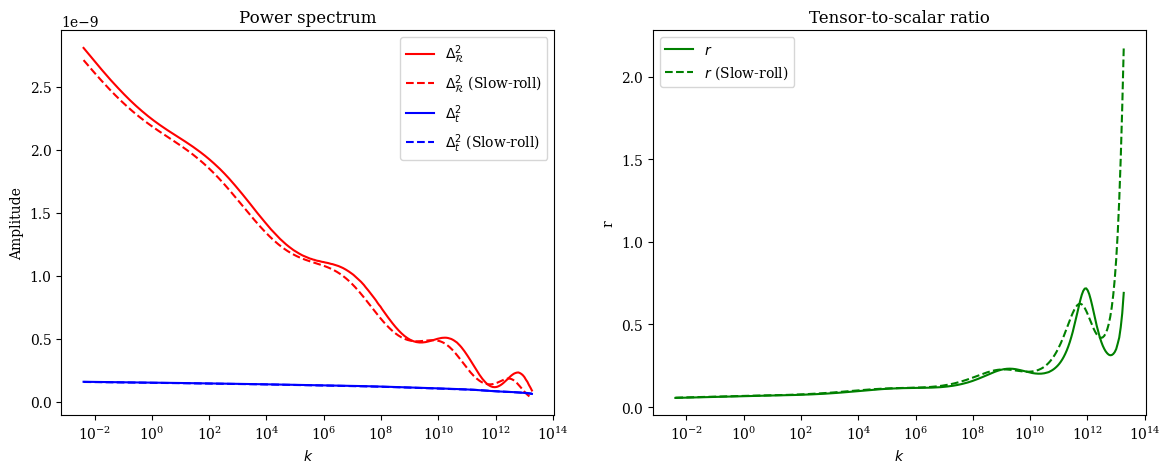

In [13]:
#Figure for the power spectrum
fig_ps = plt.figure()
fig_ps.set_figheight(5)
fig_ps.set_figwidth(14)
ax_ps = plt.subplot(1,2,1)
ax_tsr = plt.subplot(1,2,2)

ax_ps.semilogx(k_arr,P_R,color='r', linestyle='-',label=r'$\Delta^2_\mathcal{R}$')
ax_ps.semilogx(k_arr,P_R_SR,color='r', linestyle='--', label=r'$\Delta^2_\mathcal{R}$ (Slow-roll)')
ax_ps.semilogx(k_arr,P_t,color='b', linestyle='-',label=r'$\Delta^2_t$')
ax_ps.semilogx(k_arr,P_t_SR,color='b', linestyle='--', label=r'$\Delta^2_t$ (Slow-roll)')

ax_tsr.semilogx(k_arr,r,color='g', linestyle='-',label=r'$r$')
ax_tsr.semilogx(k_arr,r_SR,color='g', linestyle='--', label=r'$r$ (Slow-roll)')

ax_ps.set_xlabel(r'$k$')
ax_ps.set_ylabel('Amplitude')
ax_ps.set_title('Power spectrum')
ax_ps.legend()

ax_tsr.set_xlabel(r'$k$')
ax_tsr.set_ylabel('r')
ax_tsr.set_title('Tensor-to-scalar ratio')
ax_tsr.legend()

After obtaining the power spectrum, we can compute the scalar spectral index, in our case for $k_* = 0.05 \ MPc^{-1}$

In [14]:
k_star = 0.05
h=1e-6
k_arr = [k_star-h,k_star,k_star+h]
PR_star = []

for k in k_arr:
    # numerical integration
    a_i,N_i,N_eq,N_span = num_int_pert(k)
    N_eval = N_eq+2

    #background
    phi_back = sol_back.sol(N_eval)[0]
    dphi_back = sol_back.sol(N_eval)[1]

    uarr_0_RE = [u_0_RE(k), du_0_RE(k)]
    uarr_0_IM = [u_0_IM(k), du_0_IM(k)]

    #scalar fluctuations
    sol_u_RE = solve_ivp(MSN,N_span, uarr_0_RE, dense_output=True, args=[k])
    sol_u_IM = solve_ivp(MSN,N_span, uarr_0_IM, dense_output=True, args=[k])

    u_cross_RE = sol_u_RE.sol(N_eval)[0]
    u_cross_IM = sol_u_IM.sol(N_eval)[0]
    u_cross2 = u_cross_RE*u_cross_RE+u_cross_IM*u_cross_IM
    z_cross = dphi_back*a(N_eval)

    R_cross2 = u_cross2/z_cross/z_cross
    P_Ri = np.power(k,3)/2/np.pi/np.pi * R_cross2
    PR_star.append(P_Ri)

#scalar spectral index
ln_PR = np.log(PR_star)
ln_k = np.log(k_arr)
ln_h = ln_k[1]-ln_k[0]

ns_der = (ln_PR[-1]-ln_PR[0])/(2*ln_h)
ns = 1+ns_der
print('Scalar spectral index: %.4f'%ns)

#slow-roll
a_i,N_i,N_eq,N_span = num_int_pert(k_star)
phi_star = sol_back.sol(N_eq)[0]
dphi_star = sol_back.sol(N_eq)[1]

ns_SR = 1-4*epsN(dphi_star)+2*etaN(phi_star,dphi_star)
print('Scalar spectral index (slow-roll): %.4f'%ns_SR)

Scalar spectral index: 0.9569
Scalar spectral index (slow-roll): 0.9593
